# Homework (Week 3) -- Biometrics (20 points)

In this homework we train Biometrics Verification model and use some features to increase quality:
1) Train ECAPA-TDNN (10 points)
2) Any contrastive loss (10 points)

Link to download dataset: https://disk.yandex.ru/d/lyhtieYbxQOYqw

In [12]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import tqdm as tqdm
import urllib

import dataset

from IPython.display import clear_output

# %matplotlib inline

In [13]:
SEED = 0

np.random.seed(SEED) 
torch.manual_seed(SEED) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [14]:
# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/lyhtieYbxQOYqw'
# final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']
# !wget -O voxceleb.tar.gz "{download_url}" --no-check-certificate 
# !tar -xf voxceleb.tar.gz

### Some model train example

In [15]:
DEVICE = 'cuda'
DATADIR = 'voxceleb'
FEATS = 80
LOADER_WORKERS = 8

In [16]:
transform_mfcc = torchaudio.transforms.MFCC(
    n_mfcc=FEATS,
    melkwargs= {
        "hop_length" : 160,
        "n_mels" : FEATS
    }
)

transform_train = nn.Sequential(
    transform_mfcc,
    torchaudio.transforms.FrequencyMasking(freq_mask_param=10),
    torchaudio.transforms.TimeMasking(time_mask_param=5, p=0.1),
)

transform_test = nn.Sequential(
    transform_mfcc
)

trainset = dataset.Dataset(os.path.join(DATADIR, 'voxceleb_train'), transform_train)
testset = dataset.Dataset(os.path.join(DATADIR, 'voxceleb_test'), transform_test)
test_targets = pd.read_csv(os.path.join(DATADIR, 'target.csv')).values.tolist()

In [17]:
print(f"sampling rate     : {transform_mfcc.MelSpectrogram.sample_rate/1000} [kHz]\n"
      f"window length     : {transform_mfcc.MelSpectrogram.win_length/transform_mfcc.MelSpectrogram.sample_rate*1000} [ms]\n"
      f"window hop length : {transform_mfcc.MelSpectrogram.hop_length/transform_mfcc.MelSpectrogram.sample_rate*1000} [ms]")

sampling rate     : 16.0 [kHz]
window length     : 25.0 [ms]
window hop length : 10.0 [ms]


### Models

In [39]:
class Model(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden: int, kernel: int = 7, sride: int = 2):
        super().__init__()
        self._emb = nn.Sequential(
            nn.Conv1d(input_shape, hidden, kernel, stride=sride),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel, stride=sride),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel, stride=sride),
            nn.AdaptiveMaxPool1d(1),
        )
        self._final = nn.Sequential(
            nn.Linear(hidden, output_shape),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, X) -> tuple[torch.Tensor, torch.Tensor]:
        emb = self._emb(X).squeeze(2)
        return self._final(emb), emb

### Metrics

Cosine similarity:
$CS(a, b) = \frac{<a, b>}{\|a\| \|b\|}$

In [40]:
def cosine_similarity(a, b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

Here is O(N log N) algorithm for find best_eer:
1) Sort prediction by probability
2) Going through items and recalculating far and frr

In [41]:
def best_eer(data):
    full = sorted(data, key=lambda x: (x[0], -x[1]))
    pos = len([item for item in full if item[1] == 1])
    neg = len(full) - pos
    cur_pos = pos
    cur_neg = 0
    best_eer = 1
    for _, label in full:
        if label == 1:
            cur_pos -= 1
        else:
            cur_neg += 1
        cur_eer = max((pos - cur_pos) / pos, (neg - cur_neg) / neg)
        best_eer = min(best_eer, cur_eer)
    return best_eer

### Train

In [42]:
def train_stage(
    model: nn.Module, 
    opt: optim.Optimizer, 
    scheduler: optim.lr_scheduler.LRScheduler, 
    batch_size: int = 256
) -> None:
    train_loader = torch_data.DataLoader(
        trainset,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
        drop_last=True,
        pin_memory=True
    )
    loss_sum = 0.0
    batches = 0
    
    for X, Y, _ in tqdm.tqdm(train_loader):
        opt.zero_grad()
        logits, _ = model(X.to(DEVICE))
        loss = F.nll_loss(logits, Y.to(DEVICE))
        loss_sum += loss.item()
        batches += 1
        
        loss.backward()
        opt.step()
        
    scheduler.step()
        
    return loss_sum / batches

In [43]:
@torch.no_grad()
def calc_eval_score(model: nn.Module, batch_size: int = 256):
    val_loader = torch_data.DataLoader(
        testset,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
        pin_memory=True
    )
    items = {}
    target_scores = []
    
    # loss_sum = 0.
    
    for X, Y, pathes in tqdm.tqdm(val_loader):
        logits, embds = model(X.to(DEVICE))
        # loss = F.nll_loss(logits, Y.to(DEVICE))
        # loss_sum += loss.item()
        
        embds = embds.cpu().data.numpy().reshape(X.shape[0], -1)
        for embd, path in zip(embds, pathes):
            items[path] = embd
            
    for item1, item2, target in test_targets:
        target_scores.append((cosine_similarity(items[item1], items[item2]), target))
        
    return best_eer(target_scores)

In [44]:
def train(
    model: nn.Module,
    opt: optim.Optimizer,
    scheduler: optim.lr_scheduler.LRScheduler,
    batch_size: int = 256,
    epochs: int = 10,
    train_fun = train_stage,
    exp_dir: str = 'exp',
    loss_name: str = 'CE loss',
    train_kwargs = {},
) -> None:  
    train_losses = []
    eval_scores = []
    
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
    
    for epoch in range(epochs):
        model.train()
        train_losses.append(train_fun(model, opt, scheduler, batch_size=batch_size))
        
        model.eval()
        eval_score = calc_eval_score(model, batch_size=batch_size)
        eval_scores.append(eval_score)
        
        clear_output()
        
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label=f'train {loss_name}', marker='.')
        axis[1].plot(np.arange(1, epoch + 2), eval_scores, label='eval', marker='.')
        axis[0].set(xlabel='epoch', ylabel=loss_name)
        axis[1].set(xlabel='epoch', ylabel='EER')
        
        axis[0].tick_params(axis='x', which='minor', bottom=False)
        axis[1].tick_params(axis='x', which='minor', bottom=False)
        axis[0].grid(True, 'minor', lw=0.2); axis[0].grid(True, 'major')
        axis[1].grid(True, 'minor', lw=0.2); axis[1].grid(True, 'major')
        
        axis[0].legend(); axis[1].legend()
        plt.show()
        
        torch.save(model.state_dict(), f'{exp_dir}/model_{epoch}')
        torch.save(opt.state_dict(), f'{exp_dir}/opt_{epoch}')
        torch.save(scheduler.state_dict(), f'{exp_dir}/scheduler_{epoch}')
        
        print(f'Epoch {epoch + 1}. Train loss {train_losses[-1]}. Eval score {eval_scores[-1]}')

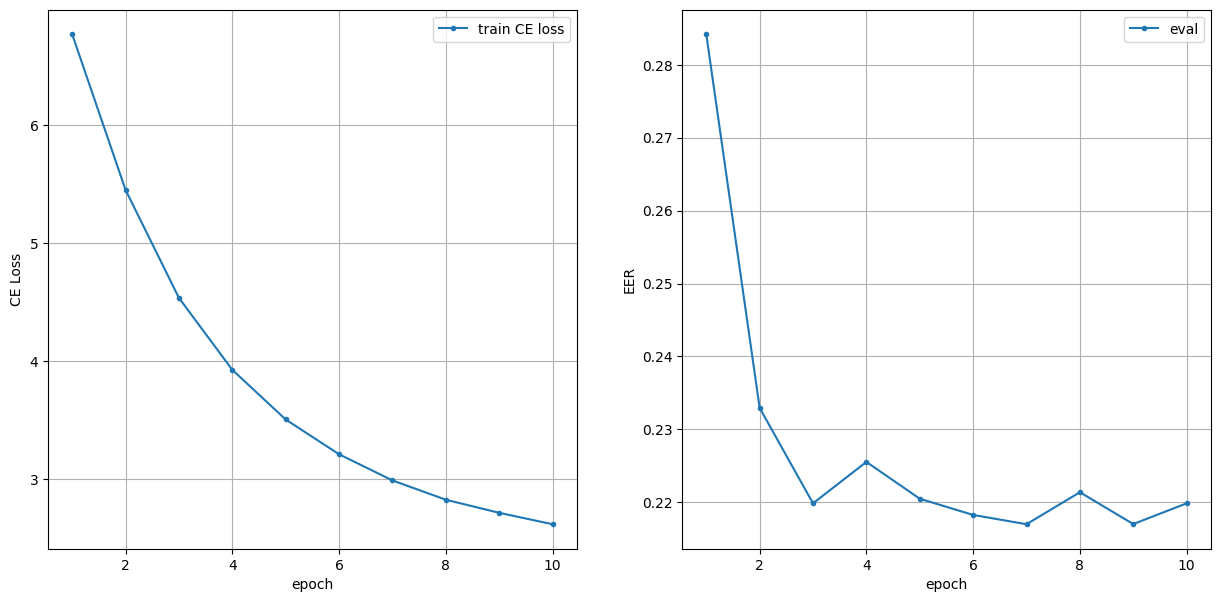

Epoch 10. Train loss 2.6193399691220485. Eval score 0.21985099128677862


In [13]:
model = Model(FEATS, trainset.speakers(), hidden=128).to(DEVICE)
opt = optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-7
)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.75)
train(
    model=model, 
    opt=opt,
    scheduler=scheduler,
    batch_size=256,
    epochs=10
)

### ECAPA TDNN (10 points)

Paper: https://arxiv.org/pdf/2005.07143.pdf

Papers for ECAPA parts:
- SE-Blocks - https://arxiv.org/pdf/1709.01507.pdf
- Res2Net - https://arxiv.org/pdf/1904.01169.pdf
- Attentive Stats Pooling - https://arxiv.org/pdf/1803.10963.pdf
- AAM Softmax - https://arxiv.org/pdf/1906.07317.pdf

Also you can optionally add other settings for paper:
- SpecAug
- Weight decay for optimizer
- LR scheduler

**Note**: In some class templates, the `__call__` method was used. However, this is a mistake. When inheriting from `nn.Module`, you should almost always override the `forward` method to ensure expected behavior. Defining `__call__` directly can cause issues, such as hooks not being tracked if they were created.

In [3]:
class SEBlock(nn.Module):
    def __init__(
        self, 
        input_channels: int, 
        reduction: int
    ) -> None:
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool1d(output_size=1)
        self.excitation = nn.Sequential(
            nn.Conv1d(
                in_channels=input_channels, 
                out_channels=input_channels//reduction, 
                kernel_size=1
            ),
            nn.ReLU(True),
            nn.Conv1d(
                in_channels=input_channels//reduction, 
                out_channels=input_channels, 
                kernel_size=1
            ),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y_squeeze = self.squeeze(x)
        y_excitation = self.excitation(y_squeeze)
        y = x * y_excitation
        
        return y

In [4]:
class Res2NetConv(nn.Module):
    def __init__(
        self,         
        hidden: int, 
        dilation: int, 
        scale: int,
        kernel_size: int = 3
    ) -> None:
        super().__init__()
        
        if hidden % scale != 0:
            raise ValueError("hidden must be divisible by scale")
        
        self.scale = scale
        
        conv2d_channels = hidden // scale
        
        self.convs2d = nn.ModuleList(
            nn.Conv1d(
                in_channels=conv2d_channels,
                out_channels=conv2d_channels,
                kernel_size=kernel_size,
                dilation=dilation,
                padding=dilation * (kernel_size - 1) // 2
            ) for _ in range(scale - 1)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[1] % self.scale == 0
        
        x_scales = torch.split(x, x.shape[1] // self.scale, dim=1)
        
        y_list = []
        
        for idx, x_curr in enumerate(x_scales):
            if idx >= 2:
                x_curr = x_curr + x_prev
            if idx >= 1:
                x_curr = self.convs2d[idx - 1](x_curr)
            
            y_list.append(x_curr)
            x_prev = x_curr
            
        y = torch.cat(y_list, dim=1)
        
        return y


class Res2Net(nn.Module):
    def __init__(
        self, 
        hidden: int, 
        dilation: int, 
        scale: int,
        reduction: int = 4,
        kernel_size: int = 3
    ) -> None:
        super().__init__()
        
        # conv2d_channels = hidden // scale
        if hidden % scale != 0:
            raise ValueError("hidden must be divisible by scale")
        
        self.scale = scale
        
        input_conv = nn.Sequential(
            nn.Conv1d(
                in_channels=hidden, 
                out_channels=hidden,
                kernel_size=1
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(num_features=hidden)
        )
        
        res2netconv = Res2NetConv(
            hidden=hidden,
            dilation=dilation,
            scale=scale,
            kernel_size=kernel_size
        )
        
        output_conv = nn.Sequential(
            nn.Conv1d(
                in_channels=hidden,
                out_channels=hidden,
                kernel_size=1
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(num_features=hidden)
        )
        
        se_block = SEBlock(
            input_channels=hidden,
            reduction=reduction
        )
        
        self.model = nn.Sequential(
            input_conv,
            res2netconv,
            output_conv,
            se_block
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x) + x

In [5]:
class EcapaBlock(nn.Module):
    def __init__(
        self, 
        input_channels: int,
        hidden: int, 
        scale: int = 8
    ) -> None:
        super().__init__()
        
        if hidden % scale != 0:
            raise ValueError("hidden must be divisible by scale")
        
        self.input_conv = nn.Sequential(
            nn.Conv1d(
                in_channels=input_channels,
                out_channels=hidden,
                kernel_size=5
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(num_features=hidden)
        )
        
        # bottleneck_dim = hidden // reduction
        self.res2net_1 = Res2Net(
            hidden=hidden,
            dilation=2,
            scale=scale,
            reduction=4,
            kernel_size=3
        )
        
        self.res2net_2 = Res2Net(
            hidden=hidden,
            dilation=3,
            scale=scale,
            reduction=4,
            kernel_size=3
        )
        
        self.res2net_3 = Res2Net(
            hidden=hidden,
            dilation=4,
            scale=scale,
            reduction=4,
            kernel_size=3
        )
        
        self.output_conv = nn.Sequential(
            nn.Conv1d(
                in_channels=3*hidden,
                out_channels=1536,
                kernel_size=1
            ),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y0 = self.input_conv(x)
        
        y1 = self.res2net_1(y0)
        y2 = self.res2net_2(y1)
        y3 = self.res2net_3(y2)
        
        y = self.output_conv(torch.cat((y1, y2, y3), dim=1))
        
        return y        

In [6]:
class AttentiveStatsPooling(nn.Module):
    def __init__(
        self, 
        input_channels: int, 
        bottleneck_channels: int = 128
    ) -> None:
        super().__init__()
        
        self.attention = nn.Sequential(
            nn.Conv1d(
                in_channels=3*input_channels,
                out_channels=bottleneck_channels,
                kernel_size=1
            ),
            nn.ReLU(inplace=True),
            nn.Conv1d(
                in_channels=bottleneck_channels,
                out_channels=input_channels,
                kernel_size=1
            ),
            nn.Softmax(dim=2)  # along the last (time dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, T = x.shape
        
        time_mean = torch.mean(x, dim=2, keepdim=True).expand(B, C, T)  # (B, C, 1) -> (B, C, T)
        time_std = torch.std(x, dim=2, keepdim=True).expand(B, C, T)  # (B, C, 1) -> (B, C, T)
        
        h = torch.cat((x, time_mean, time_std), dim=1)  # (B, 3C, T)
        
        alpha = self.attention(h)  # (B, C, T)
        
        weighted_mean = torch.sum(alpha * x, dim=2)  # (B, C)
        weighted_var = torch.sum(alpha * x**2, dim=2) - weighted_mean**2  # (B, C)
        weighted_std = torch.sqrt(torch.clamp_min(weighted_var, min=1e-9))  # (B, C)
        
        y = torch.cat((weighted_mean, weighted_std), dim=1)  # (B, C)
        
        return y   # (B, C)

In [7]:
class AAMSoftmax(nn.Module):
    def __init__(
        self, 
        input_channels: int, 
        n_classes: int, 
        margin: float = 0.2, 
        scale: float = 30.
    ) -> None:
        super().__init__()
        
        self.n_classes = n_classes
        self.margin = margin
        self.scale = scale 
        
        self.weights = nn.Parameter(torch.zeros((n_classes, input_channels), dtype=torch.float32))
        nn.init.xavier_uniform_(self.weights)
        
        self._cos_m = math.cos(self.margin)
        self._sin_m = math.sin(self.margin) 
        
        # cos(theta + m) > cos(theta) on [0; pi] if theta + m > pi
        self._cos_thres = math.cos(math.pi - self.margin)
        # linear approx. in the vicinity of (pi - margin) to preserve monotonically decreasing property 
        self._cos_m_thres_dec = math.sin(math.pi - self.margin) * self.margin

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, ch = x.shape
        
        x_norm = F.normalize(x, p=2, dim=1)  # (B, ch)
        weights_norm = F.normalize(self.weights, p=2, dim=1)  # (n_classes, ch)
        
        cos_theta = F.linear(x_norm, weights_norm).clamp(-1.0, 1.0)  # (B, n_classes)
        exp_s_cos_theta = torch.exp(self.scale * cos_theta)  # (B, n_classes)
        
        sin_theta = torch.sqrt(torch.clamp_min(1 - cos_theta**2, min=1e-9))  # (B, n_classes)
        
        # cos(theta + m)
        cos_theta_m = cos_theta * self._cos_m - sin_theta * self._sin_m  # (B, n_classes)
        cos_theta_m = torch.where(cos_theta - self._cos_thres > 0, cos_theta_m, cos_theta - self._cos_m_thres_dec)
        
        exp_s_cos_theta_m = torch.exp(self.scale * cos_theta_m)
        
        Z = torch.sum(exp_s_cos_theta, dim=1, keepdim=True) - exp_s_cos_theta + exp_s_cos_theta_m
        
        S = self.scale * cos_theta_m - torch.log(Z)
        
        return S  # (B, n_classes)

In [8]:
class EcapaTDNN(nn.Module):
    def __init__(
        self, 
        input_channels: int, 
        n_classes: int,
        hidden: int,
        bottleneck_channels: int = 128,
        embedding_dim: int = 192,
        ecapa_scale: int = 8,
    ) -> None:
        super().__init__()
        
        ecapa_block = EcapaBlock(
            input_channels=input_channels,
            hidden=hidden,
            scale=ecapa_scale
        )
        
        attentive_stat_pooling = AttentiveStatsPooling(
            input_channels=1536,
            bottleneck_channels=bottleneck_channels
        )
        
        self.emb_model = nn.Sequential(
            ecapa_block,
            attentive_stat_pooling,
            nn.BatchNorm1d(num_features=1536*2),
            nn.Linear(
                in_features=1536*2,
                out_features=embedding_dim
            ),
            nn.BatchNorm1d(num_features=embedding_dim)
        )
        
        self.head = AAMSoftmax(
            input_channels=embedding_dim,
            n_classes=n_classes,            
        )
        

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        emb = self.emb_model(x)
        outp = self.head(emb)
        
        return outp, emb

Train ECAPA model, at this point you can archive stable score (for several consecutive epochs) near 0.08 EER.

We will train ECAPA with hidden size 256 to increase training speed

In [18]:
# Check number of parameters in ecapa-tdnn with hidden=512 (as in paper).
# As one can see, number of parameters are exactly the same (6.2M)
# Nevertheless, we will use the model with hidden=256
ecapatdnn_512 = EcapaTDNN(FEATS, trainset.speakers(), hidden=512)
pn = 0
for p in ecapatdnn_512.emb_model.parameters():
    pn += p.numel()
print(f"Number of parameter for C=512: {pn/10**6:.1f}M ")

Number of parameter for C=512: 6.2M 


In [19]:
ecapatdnn = EcapaTDNN(
    input_channels=FEATS, 
    n_classes=trainset.speakers(), 
    hidden=256
).to(DEVICE)

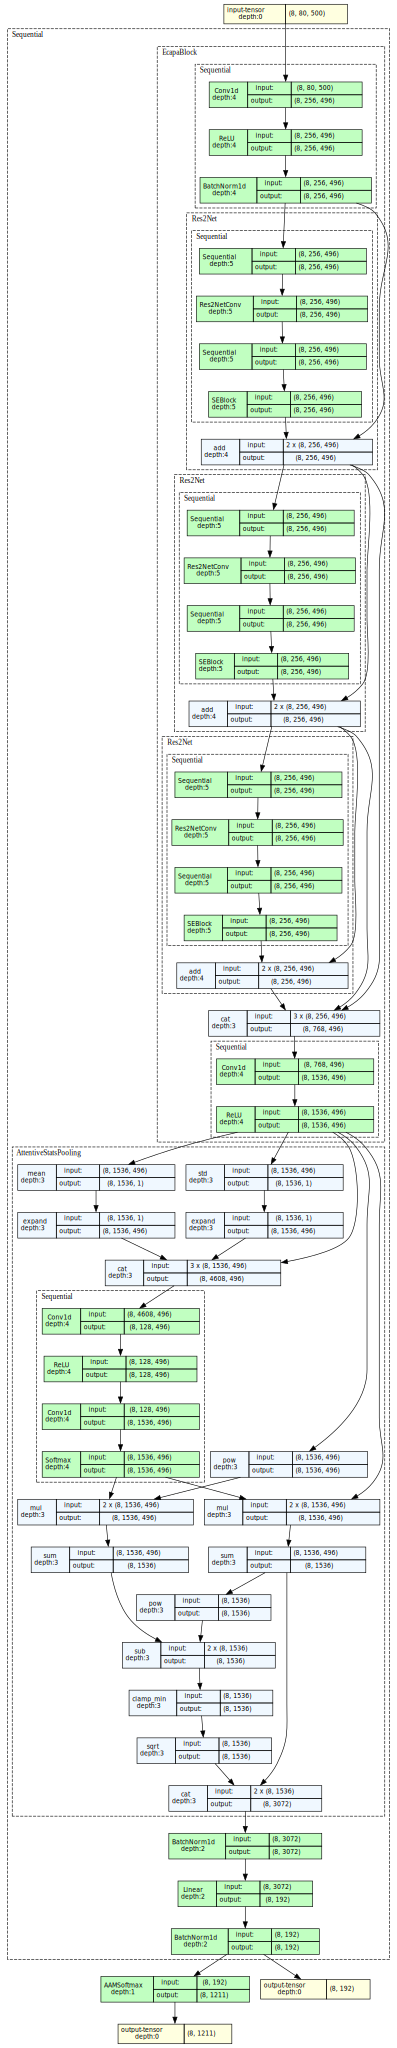

In [22]:
from torchview import draw_graph

x = torch.randn(8, 80, 500)

model_graph = draw_graph(
    ecapatdnn, 
    input_size=x.shape, 
    expand_nested=True, 
    depth=5,
    graph_dir='TB',
)
model_graph.visual_graph

In [54]:
opt_ecapatdnn = optim.Adam(
    ecapatdnn.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)

scheduler_ecapatdnn = optim.lr_scheduler.ExponentialLR(
    optimizer=opt_ecapatdnn, 
    gamma=0.75
)

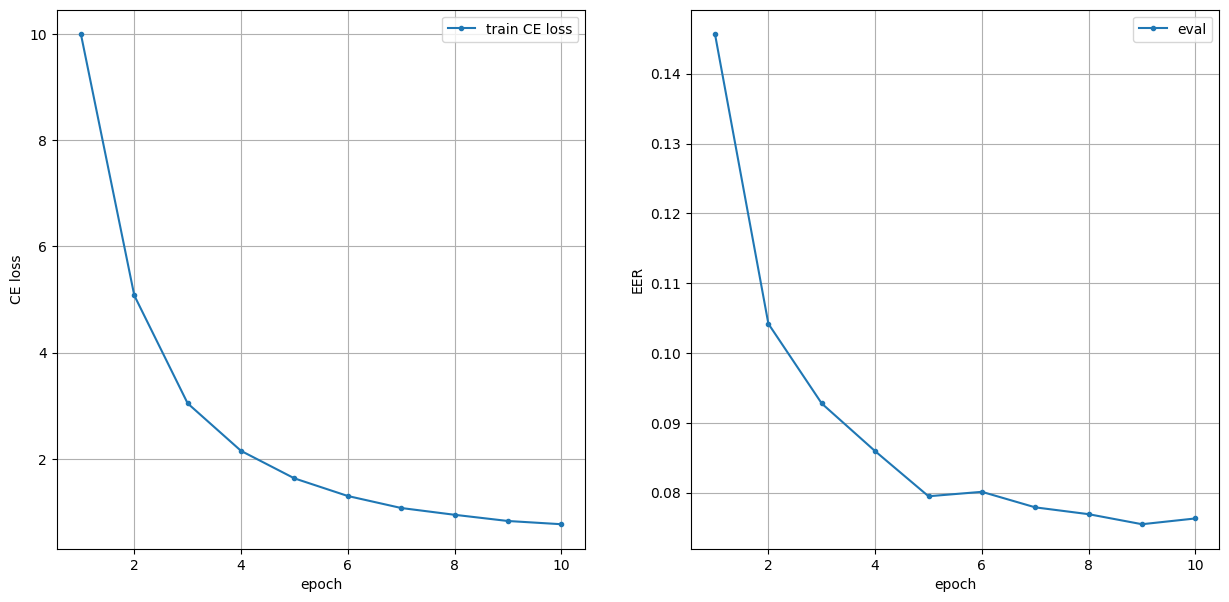

Epoch 10. Train loss 0.77024321675976. Eval score 0.07629219912263971


In [55]:
train(
    model=ecapatdnn, 
    opt=opt_ecapatdnn,
    scheduler=scheduler_ecapatdnn,
    batch_size=64,
    epochs=10,
    exp_dir='ecapa_tdnn'
)

In [56]:
# Save model to preserve results before uptraining experiments
torch.save(ecapatdnn.state_dict(), 'ecapatdnn_model.pth')
torch.save(opt_ecapatdnn.state_dict(), 'ecapatdnn_opt.pth')
torch.save(scheduler_ecapatdnn.state_dict(), 'ecapatdnn_scheduler.pth')

### Contrastive losses (10 points)

You can use anyone constrative loss.
Good article with contrastive losses https://lilianweng.github.io/posts/2021-05-31-contrastive/

Base losses:
- contrastive
- triplet -- it gives a better quality usually
- lifted structured loss -- better batch data utilization

The main problem with contrastive loss is the positive pairs sampler.
This is because a large number of classes provided only once per batch
in case of large number of classes in the dataset.

**N-Pair loss**

As we have huge number of classes (>1000), it will be more effective to use contrastive losses with many negaitve examples, such as **N-Pair loss**. For this kind of loss one can sample, for example, one anchor object $x$,  one positive $x^+$ and some negative examples $x^-_j,\; j=\overline{1,N} $ ($ N= $ `batch_size - 2`) for given anchor $x$. During contrastive uptraining model will learn to find positive sample from negatives for each given batch, encouraging better embedding representation: intra-class separability and intra-class compactness in terms of cosine similarity $s$:

$
L_{\text{N-pair}} (x,\, x^+,\, \{x_i\}_{i=1}^N) = - \log\left[\dfrac{\exp\left({s(f(x), f(x^+))}\right)}{\exp\left({s(f(x), f(x^+))}\right) + \sum\limits_{i=1}^{N} \exp\left({s(f(x), f(x^-_i))}\right)}\right],\quad s(a, b) = \dfrac{a^\mathsf{T} b}{\|a\|_2 \|b\|_2}
$

In [57]:
from collections import defaultdict
import typing as tp
import random

class NPairSampler(torch.utils.data.Sampler):
    r"""N-Pair Sampler with 1 positive and batch_size-2 negative examples per batch
    """
    def __init__(
        self, 
        speakers: list[int], 
        batch_size: int
    ) -> None:
        super().__init__()
        
        self.labels = speakers
        self.batch_size = batch_size
        
        self.num_positive = 1
        self.num_negatives = self.batch_size - 2
        
        self.label_to_ids = defaultdict(list)
        for idx, label in enumerate(self.labels):
            self.label_to_ids[label].append(idx)
            
        self.labels_list = list(self.label_to_ids.keys())

    def __len__(self) -> int:
        return len(self.labels) // self.batch_size

    def __iter__(self) -> tp.Iterator[list[int]]:
        for _ in range(len(self)):
            batch_ids = []
            
            anchor_label = random.choice(self.labels_list)
            anchor_idx, positive_idx = np.random.choice(self.label_to_ids[anchor_label], 2, replace=False)
            
            batch_ids.extend((anchor_idx, positive_idx))
            
            negative_labels_list = [i for i in self.labels_list if i != anchor_label]
            for _ in range(self.batch_size - 2):
                negative_label = random.choice(negative_labels_list)
                negative_idx = random.choice(self.label_to_ids[negative_label])
                batch_ids.append(negative_idx)
        
            yield batch_ids

In [58]:
class NPairLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
    def forward(
        self, 
        anchor: torch.Tensor, 
        positive: torch.Tensor, 
        negatives: torch.Tensor
    ) -> torch.Tensor:        
        anchor = F.normalize(anchor, p=2, dim=0)  # (emb_dim, )
        positive = F.normalize(positive, p=2, dim=0)  # (emb_dim, )
        negatives = F.normalize(negatives, p=2, dim=1)  # (num_neg, emb_dim)
        
        pos_score = (anchor @ positive).unsqueeze(0)  # (1, )
        neg_scores = (negatives @ anchor)  # (num_neg, )
        
        all_scores = torch.cat((pos_score, neg_scores), dim=0)  # (num_neg + 1, )
        
        return torch.logsumexp(all_scores, dim=-1) - pos_score

In [68]:
def contrastive_train_stage(
    model: nn.Module, 
    opt: optim.Optimizer,
    scheduler: optim.lr_scheduler.LRScheduler, 
    batch_size: int = 256
) -> float:
    # You can use any contrastive loss here to improve training
    # You can combine contrastive loss with the NLL loss after AAM softmax to improve stability
    contrastive_train_loader = torch_data.DataLoader(
        trainset,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
        pin_memory=True,
        batch_sampler=NPairSampler(trainset._speakers, batch_size)
    )
    loss_func = NPairLoss()
    
    loss_sum = 0.
    
    for X, _, _ in tqdm.tqdm(contrastive_train_loader):
        opt.zero_grad()
        _, emb = model(X.to(DEVICE))
        
        anchor_emb = emb[0]
        positive_emb = emb[1]
        negatives_emb = emb[2:]
        
        loss = loss_func(anchor_emb, positive_emb, negatives_emb)
        loss_sum += loss.item()
        
        loss.backward()
        opt.step()
        
    scheduler.step()
    
    return loss_sum / len(contrastive_train_loader)

Train model with contrastive loss here. At this point you can archive EER near 0.06-0.07 (it should be at least on 0.005 to 0.01 better than before)

In [ ]:
ecapatdnn_ut = EcapaTDNN(
    input_channels=FEATS, 
    n_classes=trainset.speakers(), 
    hidden=256
)
ecapatdnn_ut.load_state_dict(torch.load('ecapatdnn_model.pth'))
ecapatdnn_ut.to(DEVICE)

opt_ecapatdnn_ut = optim.Adam(
    ecapatdnn_ut.parameters(),
    #lr=1e-5,
    weight_decay=1e-6
)

# scheduler with warm-up
# note: it overrides optimizer's lr
scheduler_ecapatdnn_ut = torch.optim.lr_scheduler.CyclicLR(
    opt_ecapatdnn_ut, 
    base_lr=1e-7, 
    max_lr=1e-5,
    step_size_up=3,
    step_size_down=4,
    mode="triangular2"
)

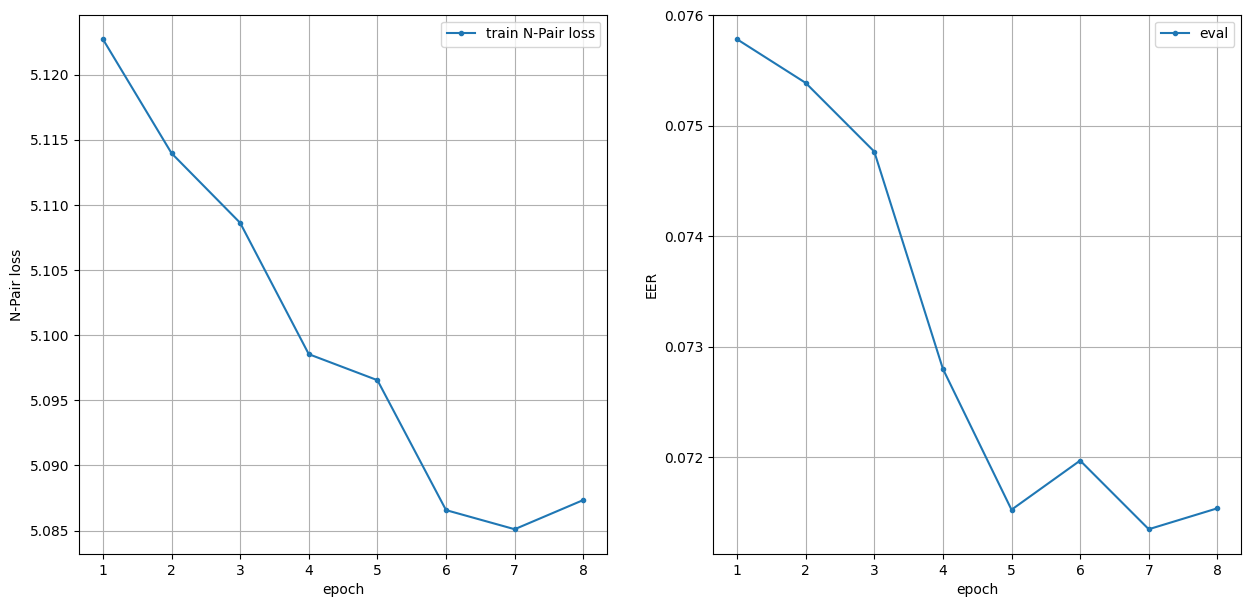

Epoch 8. Train loss 5.0873453346165745. Eval score 0.0715368102033085


In [80]:
train(
    model=ecapatdnn_ut, 
    opt=opt_ecapatdnn_ut, 
    scheduler=scheduler_ecapatdnn_ut,
    batch_size=256, 
    epochs=8,
    train_fun=contrastive_train_stage,
    exp_dir='ecapa_tdnn_contrastive_ut',
    loss_name='N-Pair loss'
)

Using contrastive uptraining (N-pair Loss), we successfully enhanced EER by by ~0.005, up to ~0.0715

In [81]:
torch.save(ecapatdnn_ut.state_dict(), 'ecapatdnn_model_ut.pth')
torch.save(opt_ecapatdnn_ut.state_dict(), 'ecapatdnn_opt_ut.pth')
torch.save(scheduler_ecapatdnn_ut.state_dict(), 'ecapatdnn_scheduler_ut.pth')